STAT 453: Deep Learning (Fall 2025)    
Instructor: Ben Lengerich

*Credits due to Yiqiao Zhong, Sebastian Raschka, Baiheng Chen*


Course website: https://adaptinfer.org/dgm-fall-2025/
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

---

Note that Python's Imaging Library (PIL) can be installed via

    conda install pillow

**If you have any installation issues, please don't hesitate to ask via Canvas!**

# Submit a clear HTML file generated from this hw3.ipynb for easier grading. (5 pts)

# HW 3: Graduate Student Descent! Training and Tuning a Multilayer Perceptron (40 pts)

**Your task in this homework is to take this existing Multilayer Perceptron implementation and change it to achieve a better performance on [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist).**

---
<font color='darkred'>
For the successfull outcome of this homework:
    
- Your Validation and Test set accuracies should be

     - greater than 85% for 10 pts
     - greater than 86% for 20 pts
     - greater than 87% for 30 pts
     - greater than 88% for 40 pts    
    

- Answer the questions at the bottom of this notebook
- Submit this Jupyter Notebook with your modifications as .ipynb and .html file to Canvas (similar to previous homeworks)
</font>
---


Please read and execute this notebook first to make sure everything works correctly. Then, feel free to make any changes to the architecture, i.e., you can change

- the number of layers
- the activation function(s) (logistic sigmoid, tanh, relu, leaky relu, ...)
- the learning rate
- the number of hidden layers
- the number of units in the hidden layer(s)
- the number of epochs
- the minibatch size

However,

- don't change the weight initialization
- don't change the random seed
- don't change the optimization algorithm

The cells where you can/should make changes are clearly highlighted. For instance, I added comments as shown below:

```

```

In [1]:
import torch
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Hints: Colab provides free GPUs, so feel free to use them to speed up your calculations. Jupyter Notebook may have GPU access if you’re using a computer with a good graphics card.

In [2]:
# No need to change anything here!
# If there is a GPU available, it will use it,
# otherwise, it will use the CPU

RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Loading the Dataset

The dataset consists of 10 classes similar to the original MNIST dataset. Also, it shares the same overall structure with MNIST, i.e., there are 60k training images and 10k test images, and all images are black & white images of size 28x28.

Below is an example of how the images look like:

![](figures/fashion-mnist-sprite.png)

(Image Source: https://github.com/zalandoresearch/fashion-mnist)



The 10 classes in this dataset are


| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## Proprocess the dataset


<font color='darkred'>

---

Before you continue, please execute the companion notebook "Notebook for Preparing the Dataset for HW3" ([`hw3-dataprep.ipynb`](hw3-dataprep.ipynb)) for downloading and preparing the dataset.

---
<font>


---

## Dataset Loader (30 pts)

In [13]:
from hw3_FashionMNISTDataset import FashionMNISTDataset
#!unzip -o png-files.zip
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

import os

In [14]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

custom_train_transform = transforms.Compose([
                                             transforms.RandomHorizontalFlip(p=0.5),
                                             transforms.RandomRotation(10),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [15]:
####################################################################
# THIS CELL CAN BE MODIFIED BUT THERE SHOULD NOT BE ANY RANDOMNESS
####################################################################

custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [16]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

BATCH_SIZE = 128

In [17]:
train_dataset = FashionMNISTDataset(csv_path='train.csv',
                                    img_dir='png-files/',
                                    transform=custom_train_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=4)


valid_dataset = FashionMNISTDataset(csv_path='valid.csv',
                                    img_dir='png-files/',
                                    transform=custom_test_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)


test_dataset = FashionMNISTDataset(csv_path='test.csv',
                                   img_dir='png-files/',
                                   transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: T

### Show the sample sizes of the training, validation, and testing sets. 10 points each

In [18]:
### sample size of training set (10 pts)
print("Number of training samples:", len(train_dataset))

### sample size of validation set (10 pts)
print("Number of validation samples:", len(valid_dataset))

### sample size of testing set (10 pts)
print("Number of testing samples:", len(test_dataset))

Number of training samples: 55000
Number of validation samples: 5000
Number of testing samples: 10000


The cell below just checks if the dataset can be loaded correctly.

In [19]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):

        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(DEVICE)
        y = y.to(DEVICE)

        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 128
break minibatch for-loop


If you get an error, make sure the `png-files` folder is unzipped and it the same directory as this notebook!

# Multilayer Perceptron Model

The cell below contains the multi-layer perceptron model. This is the main section where you want to make changes to the architecture.

In [20]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################


class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super(MLP, self).__init__()

        self.num_classes = num_classes

        ### ADD ADDITIONAL LAYERS BELOW IF YOU LIKE
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.bn1 = torch.nn.BatchNorm1d(num_hidden_1)
        self.dropout1 = torch.nn.Dropout(p=0.3)
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.bn2 = torch.nn.BatchNorm1d(num_hidden_2)
        self.dropout2 = torch.nn.Dropout(p=0.3)

        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)

    def forward(self, x):

        ### MAKE SURE YOU CONNECT THE LAYERS PROPERLY IF YOU CHANGED
        ### ANYTHNG IN THE __init__ METHOD ABOVE
        x = F.relu(self.bn1(self.linear_1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.linear_2(x)))
        x = self.dropout2(x)
        logits = self.linear_out(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas


#################################
### Model Initialization
#################################


# the random seed makes sure that the random weight initialization
# in the model is always the same.
# In practice, some weights don't work well, and we may also want
# to try different random seeds. In this homework, this is not
# necessary.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### IF YOU CHANGED THE ARCHITECTURE ABOVE, MAKE SURE YOU
### ACCOUNT FOR IT VIA THE PARAMETERS BELOW. I.e., if you
### added a second hidden layer, you may want to add a
### hidden_2 parameter here. Also you may want to play
### with the number of hidden units.
model = MLP(num_features=28*28,
            num_hidden_1=512,
            num_hidden_2=256,
            num_classes=10)

model = model.to(DEVICE)




In [21]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

### For this homework, do not change the optimizer. However, you
### likely want to experiment with the learning rate!
optimizer = torch.optim.SGD(model.parameters(), lr=0.035, momentum=0.9)
############################################################

In [22]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

NUM_EPOCHS = 38 # Please feel free to change
############################################################

In [23]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):

        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples


start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):

    model.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 20:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |'
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')

    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/038 | Batch 000/429 | Cost: 2.3829
Epoch: 001/038 | Batch 020/429 | Cost: 0.8732
Epoch: 001/038 | Batch 040/429 | Cost: 0.7156
Epoch: 001/038 | Batch 060/429 | Cost: 0.6644
Epoch: 001/038 | Batch 080/429 | Cost: 0.5930
Epoch: 001/038 | Batch 100/429 | Cost: 0.7031
Epoch: 001/038 | Batch 120/429 | Cost: 0.6452
Epoch: 001/038 | Batch 140/429 | Cost: 0.7455
Epoch: 001/038 | Batch 160/429 | Cost: 0.5817
Epoch: 001/038 | Batch 180/429 | Cost: 0.5284
Epoch: 001/038 | Batch 200/429 | Cost: 0.6939
Epoch: 001/038 | Batch 220/429 | Cost: 0.6699
Epoch: 001/038 | Batch 240/429 | Cost: 0.5633
Epoch: 001/038 | Batch 260/429 | Cost: 0.4237
Epoch: 001/038 | Batch 280/429 | Cost: 0.6010
Epoch: 001/038 | Batch 300/429 | Cost: 0.4897
Epoch: 001/038 | Batch 320/429 | Cost: 0.5007
Epoch: 001/038 | Batch 340/429 | Cost: 0.6516
Epoch: 001/038 | Batch 360/429 | Cost: 0.3787
Epoch: 001/038 | Batch 380/429 | Cost: 0.4597
Epoch: 001/038 | Batch 400/429 | Cost: 0.6155
Epoch: 001/038 | Batch 420/429 | C

# Evaluation (No Need To Change Any Code in This Section!, 5 pts)

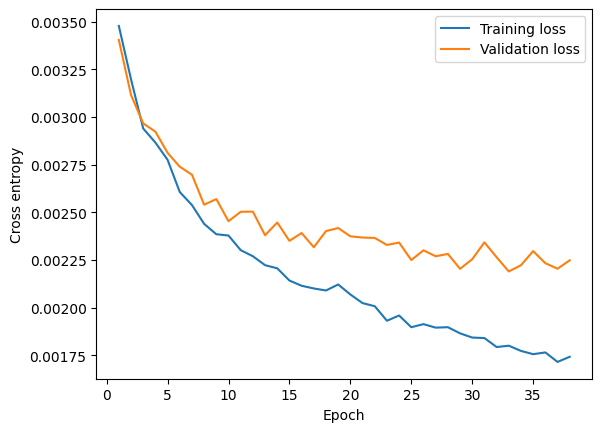

In [24]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

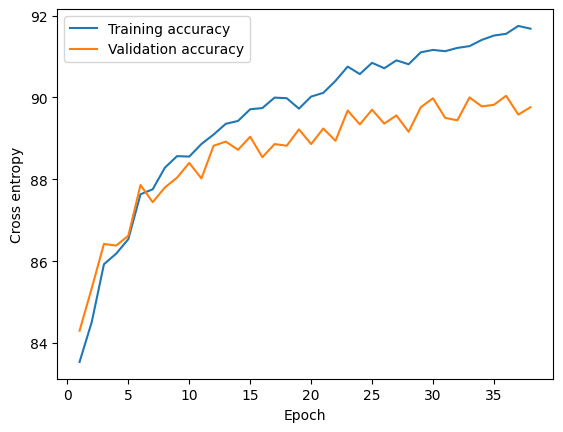

In [26]:
plt.plot(range(1, NUM_EPOCHS+1), [x.cpu().item() if torch.is_tensor(x) else x for x in train_acc_lst], label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), [x.cpu().item() if torch.is_tensor(x) else x for x in valid_acc_lst], label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()


In [27]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 88.98%


# Conclusions (YOUR ANSWERS REQUIRED, 20 pts, grading will be based on completeness rather than correctness.)

**1) What is your training, validation, and test accuracy (paste your numbers from above)? Also, do you notice any overfitting? If yes, why do you think your model is overfitting, and what would be a simple technique to reduce overfitting?**

[Your answers here]

- Training:  91.68%
- Validation: 89.76%
- Test 88.98%

Yes, there is mild overfitting — the training accuracy is slightly higher than the validation and test accuracies. The model might be too complex or has trained for too many epochs, allowing it to memorize training examples. Apply dropout or increase data augmentation (e.g., random rotations, flips) to make the model more robust.

**3) Assuming you increased the accuracy by 3%, how many more correct predictions did the improved model make in the test set?**

0.8898×10000=8898
0.9198×10000=9198
9198−8898=300